In [2]:
# ==========================================
# 1. INSTALLATION & IMPORTATIONS
# ==========================================
print("Installation et importation des bibliothèques")
!pip install -q transformers datasets gensim scikit-learn matplotlib seaborn torch tqdm

import os, re, random, requests, shutil, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

Installation et importation des bibliothèques


In [3]:
# ==========================================
# 2. CONFIGURATION DU PROJET
# ==========================================
class ProjectConfig:
    SEED = 42
    MAX_LEN = 128
    BATCH_SIZE = 32
    EPOCHS = 100
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 0.1
    PATIENCE = 4
    MODEL_NAME = 'roberta-base'
    OUTPUT_DIR = './meilleur_modele_fake_news'
    ZIP_NAME = 'mon_modele_fake_news'
    FILES = {
        "politifact_fake": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_fake.csv",
        "politifact_real": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_real.csv",
        "gossipcop_fake": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv",
        "gossipcop_real": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv"
    }

def set_seed(seed_val):
    random.seed(seed_val); np.random.seed(seed_val)
    torch.manual_seed(seed_val); torch.cuda.manual_seed_all(seed_val)

set_seed(ProjectConfig.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Configuration terminée. Utilisation de {torch.cuda.device_count()} GPU(s).")

✓ Configuration terminée. Utilisation de 2 GPU(s).


In [4]:
# ==========================================
# 3. FOCAL LOSS (NOUVEAU: Pour l'imbalance)
# ==========================================
class FocalLoss(nn.Module):
    """
    Loss function that focuses on hard examples (minority class).
    Replaces standard CrossEntropy to fight class imbalance.
    """
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [5]:
# ==========================================
# 4. OUTILS PÉDAGOGIQUES
# ==========================================
class Pedagogie:
    @staticmethod
    def expliquer_tokenization(texte, tokenizer):
        print(f"\n🔍 [DÉMO TECHNIQUE] Vision de l'IA pour : '{texte}'")
        tokens = tokenizer.tokenize(texte)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        print(f"   1. Découpage (Tokens) : {tokens}")
        print(f"   2. Numérisation (IDs) : {ids}")
        print("   -> L'IA ne comprend que ces nombres, pas les mots.\n")

    @staticmethod
    def analyser_erreurs(model, loader, tokenizer, device, dataset_name, num_exemples=3):
        model.eval()
        erreurs = []
        print(f"\n🕵️ [ANALYSE D'ERREURS] Où {dataset_name} s'est-il trompé ?")
        
        with torch.no_grad():
            for batch, labels in loader:
                input_ids = batch['input_ids'].to(device)
                outputs = model(input_ids, attention_mask=batch['attention_mask'].to(device))
                preds = torch.argmax(outputs.logits, dim=1)
                
                idx_erreurs = (preds != labels.to(device)).nonzero(as_tuple=True)[0]
                
                for idx in idx_erreurs:
                    if len(erreurs) >= num_exemples: break
                    texte = tokenizer.decode(input_ids[idx], skip_special_tokens=True)
                    vrai = "Faux" if labels[idx] == 1 else "Vrai"
                    pred = "Faux" if preds[idx] == 1 else "Vrai"
                    erreurs.append(f"   🔴 Texte : \"{texte[:80]}...\"\n      Réalité : {vrai} | IA a pensé : {pred}")
                if len(erreurs) >= num_exemples: break
        
        for e in erreurs: print(e + "\n")

    @staticmethod
    def visualiser_distribution(df, nom_dataset):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.countplot(x='label', data=df, palette=['green', 'red'])
        plt.title(f'Distribution : {nom_dataset.upper()}')
        plt.xticks([0, 1], ['Vrai (Real)', 'Faux (Fake)'])
        plt.ylabel("Nombre d'articles")
        
        plt.subplot(1, 2, 2)
        df['len'] = df['title'].astype(str).apply(lambda x: len(x.split()))
        sns.histplot(data=df, x='len', hue='label', kde=True, palette=['green', 'red'])
        plt.title('Longueur des titres (mots)')
        plt.tight_layout()
        plt.show()

In [6]:
# ==========================================
# 5. VISUALISATION DES RÉSULTATS
# ==========================================
class Visualizer:
    @staticmethod
    def plot_history(history, dataset_name):
        epochs = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b-o', label='Perte Entraînement')
        plt.title(f'{dataset_name} : Apprentissage (Loss)')
        plt.xlabel('Époques'); plt.ylabel('Perte'); plt.legend(); plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['val_f1'], 'g-o', label='Score F1 Validation')
        plt.title(f'{dataset_name} : Performance (F1 Score)')
        plt.xlabel('Époques'); plt.ylabel('Score F1'); plt.legend(); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, dataset_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Vrai', 'Faux'], yticklabels=['Vrai', 'Faux'])
        plt.title(f'Matrice de Confusion : {dataset_name}')
        plt.ylabel('Réel'); plt.xlabel('Prédit'); plt.show()

In [7]:
# ==========================================
# 6. GESTION DES DONNÉES
# ==========================================
class DataHandler:
    @staticmethod
    def load_csv_data(files):
        print("  -> Téléchargement des fichiers CSV...")
        dfs = []
        for name, url in files.items():
            fname = f"{name}.csv"
            if not os.path.exists(fname):
                with open(fname, 'wb') as f: f.write(requests.get(url).content)
            try: df = pd.read_csv(fname)
            except: df = pd.read_csv(fname, sep=',', on_bad_lines='skip')
            df['label'] = 1 if "fake" in name else 0
            df['dataset_source'] = 'gossipcop' if 'gossipcop' in name else 'politifact'
            dfs.append(df)
        return pd.concat(dfs, ignore_index=True)

    @staticmethod
    def afficher_statistiques(df, nom_dataset):
        print(f"\n--- 📊 ANALYSE EXPLORATOIRE (EDA) : {nom_dataset.upper()} ---")
        dist = df['label'].value_counts()
        total = len(df)
        if total == 0: return

        print(f"1. Distribution des classes :")
        print(f"   - Vrai (Real) : {dist.get(0, 0)} ({dist.get(0, 0)/total:.1%})")
        print(f"   - Faux (Fake) : {dist.get(1, 0)} ({dist.get(1, 0)/total:.1%})")
        
        doublons = df.duplicated(subset=['title']).sum()
        if doublons > 0:
            print(f"⚠️ 3. Doublons (AVANT nettoyage) : {doublons}")
        else:
            print(f"✅ 3. Doublons : Aucun.")
        print("-" * 50)

    @staticmethod
    def prepare(df, source):
        print(f"  -> Préparation des données pour : {source.upper()}")
        sub = df[df['dataset_source'] == source].copy()
        sub['clean_text'] = sub['title'].astype(str).str.lower()
        sub.dropna(subset=['clean_text'], inplace=True)
        
        # STRICT DEDUPLICATION
        before = len(sub)
        sub.drop_duplicates(subset=['clean_text'], inplace=True)
        after = len(sub)
        print(f"     [Nettoyage] {before - after} doublons supprimés.")
        
        sub['label'] = sub['label'].astype(int) 
        return sub

class FastDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {key: val[i] for key, val in self.encodings.items()}, self.labels[i]

def get_weighted_loader(dataset, labels, batch_size):
    print("  -> Équilibrage des classes (Weighted Sampling)...")
    labels_np = np.array(labels, dtype=int)
    class_counts = np.bincount(labels_np)
    if len(class_counts) < 2: return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    weights = 1. / class_counts
    samples_weights = [weights[l] for l in labels_np]
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=2)

In [8]:
# ==========================================
# 7. ENTRAÎNEUR (MODIFIÉ POUR FOCAL LOSS)
# ==========================================
class Trainer:
    def __init__(self, model, train_loader, val_loader):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = AdamW(model.parameters(), lr=ProjectConfig.LEARNING_RATE, weight_decay=ProjectConfig.WEIGHT_DECAY)
        self.scaler = GradScaler()
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*ProjectConfig.EPOCHS)
        self.history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
        self.best_f1 = 0
        self.best_state = None
        
        # Initialisation de la Focal Loss
        self.criterion = FocalLoss(gamma=2.0).to(device)

    def train(self):
        patience = 0
        print(f"\n🚀 [Démarrage] Entraînement sur {ProjectConfig.EPOCHS} époques avec Focal Loss...")
        
        for epoch in range(ProjectConfig.EPOCHS):
            self.model.train()
            total_loss = 0
            
            loop = tqdm(self.train_loader, leave=False, desc=f"Époque {epoch+1}/{ProjectConfig.EPOCHS}")
            
            for batch, labels in loop:
                self.model.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = labels.to(device)
                
                with autocast():
                    # Note: On ne passe PAS 'labels' au modèle pour éviter le calcul automatique de la Loss standard
                    outputs = self.model(input_ids, attention_mask=attention_mask)
                    loss = self.criterion(outputs.logits, labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.scheduler.step()
                total_loss += loss.item()
                loop.set_postfix(perte=loss.item())

            avg_val_loss, val_f1, _, _ = self.evaluate()
            self.history['train_loss'].append(total_loss/len(self.train_loader))
            self.history['val_loss'].append(avg_val_loss)
            self.history['val_f1'].append(val_f1)
            
            print(f"   -> Époque {epoch+1} | Perte: {self.history['train_loss'][-1]:.4f} | F1 Val: {val_f1:.4f}")
            
            if val_f1 > self.best_f1:
                self.best_f1 = val_f1
                model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
                self.best_state = copy.deepcopy(model_to_save.state_dict())
                patience = 0
            else:
                patience += 1
                if patience >= ProjectConfig.PATIENCE:
                    print(f"   🛑 Arrêt précoce (Early Stopping).")
                    break
        return self.history, self.best_f1

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        preds, targets = [], []
        with torch.no_grad():
            for batch, labels in self.val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = labels.to(device)
                
                outputs = self.model(input_ids, attention_mask=attention_mask)
                loss = self.criterion(outputs.logits, labels) # Use Focal Loss for Eval too
                
                total_loss += loss.item()
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                targets.extend(labels.cpu().numpy())
        return total_loss/len(self.val_loader), f1_score(targets, preds), targets, preds


=== Phase 1 : Chargement des Données ===
  -> Téléchargement des fichiers CSV...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]


🔍 [DÉMO TECHNIQUE] Vision de l'IA pour : 'Fake news spreads fast.'
   1. Découpage (Tokens) : ['Fake', 'Ġnews', 'Ġspreads', 'Ġfast', '.']
   2. Numérisation (IDs) : [38193, 340, 16268, 1769, 4]
   -> L'IA ne comprend que ces nombres, pas les mots.


=== Phase 2 : Entraînement ===

DATASET : POLITIFACT

--- 📊 ANALYSE EXPLORATOIRE (EDA) : POLITIFACT ---
1. Distribution des classes :
   - Vrai (Real) : 624 (59.1%)
   - Faux (Fake) : 432 (40.9%)
⚠️ 3. Doublons (AVANT nettoyage) : 73
--------------------------------------------------


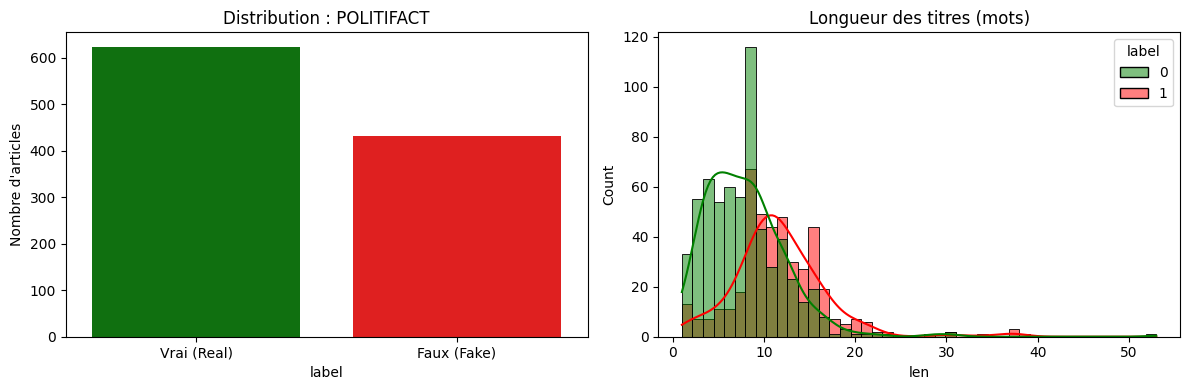

  -> Préparation des données pour : POLITIFACT
     [Nettoyage] 73 doublons supprimés.
  -> Équilibrage des classes (Weighted Sampling)...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 [Démarrage] Entraînement sur 100 époques avec Focal Loss...


Époque 1/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 1 | Perte: 0.1740 | F1 Val: 0.7826


Époque 2/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 2 | Perte: 0.1169 | F1 Val: 0.8060


Époque 3/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 3 | Perte: 0.0596 | F1 Val: 0.8281


Époque 4/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 4 | Perte: 0.0537 | F1 Val: 0.8413


Époque 5/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 5 | Perte: 0.0332 | F1 Val: 0.8462


Époque 6/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 6 | Perte: 0.0272 | F1 Val: 0.8438


Époque 7/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 7 | Perte: 0.0288 | F1 Val: 0.8413


Époque 8/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 8 | Perte: 0.0491 | F1 Val: 0.8485


Époque 9/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 9 | Perte: 0.0187 | F1 Val: 0.8346


Époque 10/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 10 | Perte: 0.0081 | F1 Val: 0.8387


Époque 11/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 11 | Perte: 0.0058 | F1 Val: 0.8358


Époque 12/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 12 | Perte: 0.0069 | F1 Val: 0.8504


Époque 13/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 13 | Perte: 0.0049 | F1 Val: 0.8504


Époque 14/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 14 | Perte: 0.0048 | F1 Val: 0.8571


Époque 15/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 15 | Perte: 0.0039 | F1 Val: 0.8154


Époque 16/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 16 | Perte: 0.0079 | F1 Val: 0.8644


Époque 17/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 17 | Perte: 0.0053 | F1 Val: 0.8244


Époque 18/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 18 | Perte: 0.0051 | F1 Val: 0.8413


Époque 19/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 19 | Perte: 0.0037 | F1 Val: 0.8333


Époque 20/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 20 | Perte: 0.0066 | F1 Val: 0.8819


Époque 21/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 21 | Perte: 0.0047 | F1 Val: 0.8676


Époque 22/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 22 | Perte: 0.0127 | F1 Val: 0.8551


Époque 23/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 23 | Perte: 0.0109 | F1 Val: 0.8387


Époque 24/100:   0%|          | 0/27 [00:00<?, ?it/s]

   -> Époque 24 | Perte: 0.0029 | F1 Val: 0.8615
   🛑 Arrêt précoce (Early Stopping).


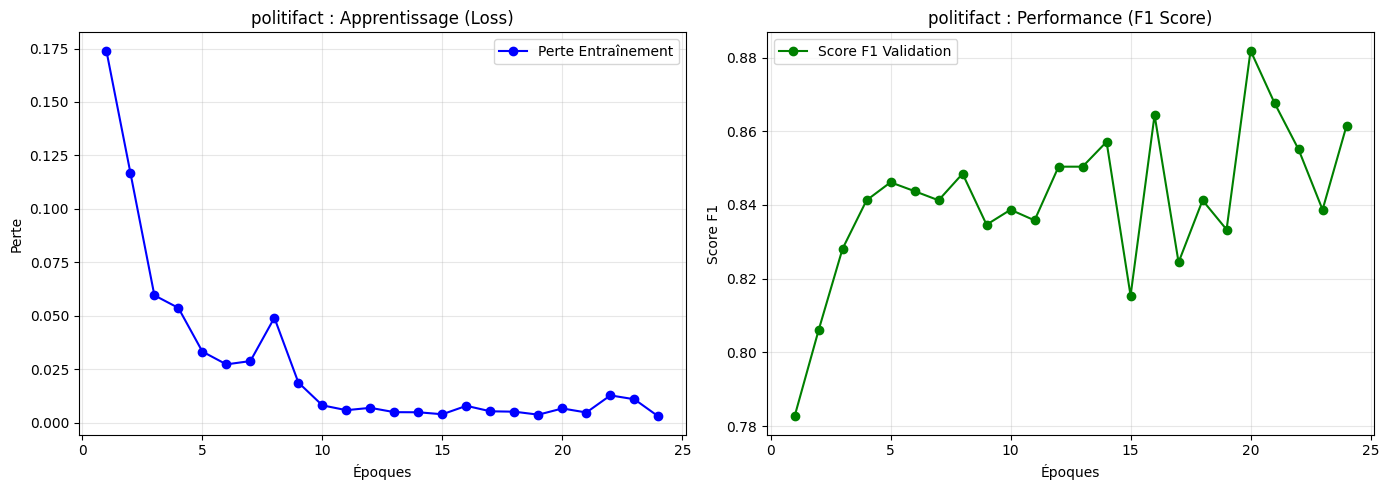


🕵️ [ANALYSE D'ERREURS] Où politifact s'est-il trompé ?
   🔴 Texte : "information for the nation..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "80% of black men in atlanta are homosexuals, study says..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "un refugee agency welcomes arrival of 10,000th syrian refugee resettled to unite..."
      Réalité : Vrai | IA a pensé : Faux



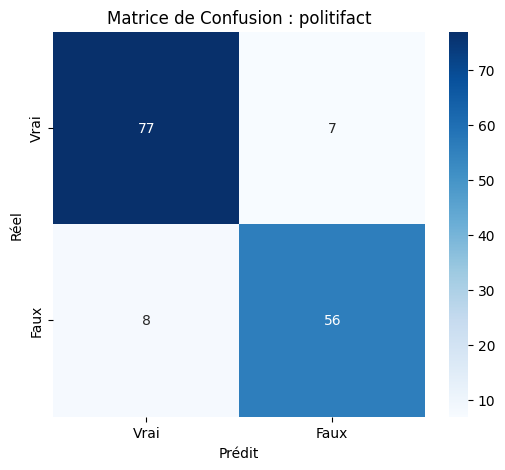


📄 [Rapport : POLITIFACT]
              precision    recall  f1-score   support

        Vrai       0.91      0.92      0.91        84
        Faux       0.89      0.88      0.88        64

    accuracy                           0.90       148
   macro avg       0.90      0.90      0.90       148
weighted avg       0.90      0.90      0.90       148


DATASET : GOSSIPCOP

--- 📊 ANALYSE EXPLORATOIRE (EDA) : GOSSIPCOP ---
1. Distribution des classes :
   - Vrai (Real) : 16817 (76.0%)
   - Faux (Fake) : 5323 (24.0%)
⚠️ 3. Doublons (AVANT nettoyage) : 1397
--------------------------------------------------


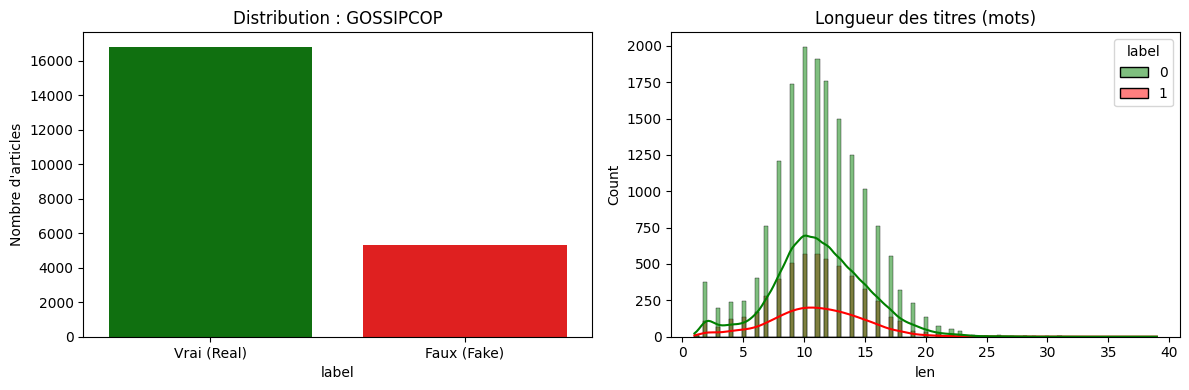

  -> Préparation des données pour : GOSSIPCOP
     [Nettoyage] 1403 doublons supprimés.
  -> Équilibrage des classes (Weighted Sampling)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 [Démarrage] Entraînement sur 100 époques avec Focal Loss...


Époque 1/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 1 | Perte: 0.1242 | F1 Val: 0.6326


Époque 2/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 2 | Perte: 0.0947 | F1 Val: 0.6448


Époque 3/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 3 | Perte: 0.0757 | F1 Val: 0.6384


Époque 4/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 4 | Perte: 0.0594 | F1 Val: 0.6370


Époque 5/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 5 | Perte: 0.0455 | F1 Val: 0.6370


Époque 6/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 6 | Perte: 0.0353 | F1 Val: 0.6614


Époque 7/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 7 | Perte: 0.0276 | F1 Val: 0.6504


Époque 8/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 8 | Perte: 0.0238 | F1 Val: 0.6400


Époque 9/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 9 | Perte: 0.0206 | F1 Val: 0.6272


Époque 10/100:   0%|          | 0/551 [00:00<?, ?it/s]

   -> Époque 10 | Perte: 0.0178 | F1 Val: 0.6399
   🛑 Arrêt précoce (Early Stopping).


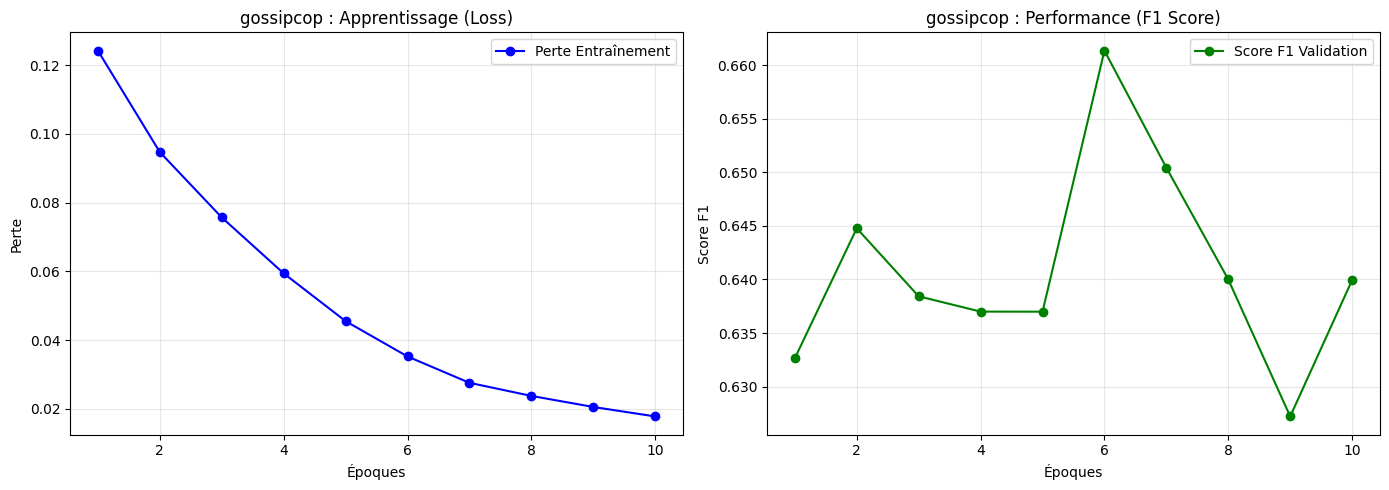


🕵️ [ANALYSE D'ERREURS] Où gossipcop s'est-il trompé ?
   🔴 Texte : "game of thrones star sophie turner is engaged to joe jonas..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "chris brown, soulja boy feud over karreuche tran..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "lockwood's daughter..."
      Réalité : Vrai | IA a pensé : Faux



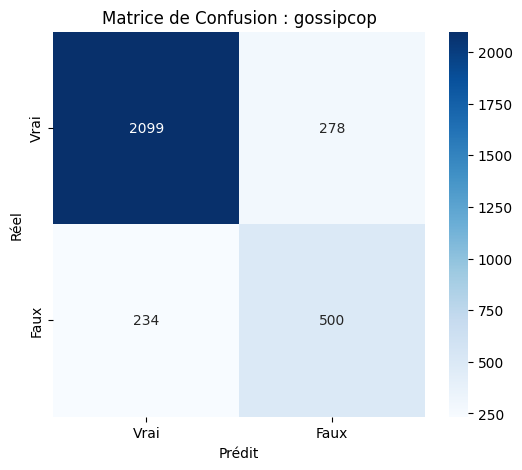


📄 [Rapport : GOSSIPCOP]
              precision    recall  f1-score   support

        Vrai       0.90      0.88      0.89      2377
        Faux       0.64      0.68      0.66       734

    accuracy                           0.84      3111
   macro avg       0.77      0.78      0.78      3111
weighted avg       0.84      0.84      0.84      3111



In [9]:
# ==========================================
# 8. EXÉCUTION PRINCIPALE
# ==========================================
print("\n=== Phase 1 : Chargement des Données ===")
full_df = DataHandler.load_csv_data(ProjectConfig.FILES)
tokenizer = RobertaTokenizer.from_pretrained(ProjectConfig.MODEL_NAME)

Pedagogie.expliquer_tokenization("Fake news spreads fast.", tokenizer)

results_summary = {}
datasets_to_run = ['politifact', 'gossipcop']

print(f"\n=== Phase 2 : Entraînement ===")

for ds_name in datasets_to_run:
    print(f"\n{'='*60}\nDATASET : {ds_name.upper()}\n{'='*60}")
    
    # Préparation
    df_raw = full_df[full_df['dataset_source'] == ds_name]
    DataHandler.afficher_statistiques(df_raw, ds_name)
    Pedagogie.visualiser_distribution(df_raw, ds_name)

    df_sub = DataHandler.prepare(full_df, ds_name)
    if len(df_sub) < 50: continue

    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        df_sub['clean_text'].values, df_sub['label'].values, 
        test_size=0.15, stratify=df_sub['label'].values, random_state=42
    )
    
    # Loaders
    # Note: On garde le WeightedRandomSampler en plus de la Focal Loss pour maximiser l'effet
    train_dl = get_weighted_loader(FastDataset(X_train, y_train, tokenizer, ProjectConfig.MAX_LEN), y_train, ProjectConfig.BATCH_SIZE)
    val_dl = DataLoader(FastDataset(X_val, y_val, tokenizer, ProjectConfig.MAX_LEN), batch_size=ProjectConfig.BATCH_SIZE, num_workers=2)
    
    model = RobertaForSequenceClassification.from_pretrained(ProjectConfig.MODEL_NAME, num_labels=2)
    model.to(device)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    # Train
    trainer = Trainer(model, train_dl, val_dl)
    history, best_f1 = trainer.train()
    results_summary[ds_name] = {'f1': best_f1, 'state': trainer.best_state}
    
    # Visualisation
    Visualizer.plot_history(history, ds_name)
    
    if hasattr(model, 'module'): model.module.load_state_dict(trainer.best_state)
    else: model.load_state_dict(trainer.best_state)
    
    Pedagogie.analyser_erreurs(model, val_dl, tokenizer, device, ds_name)
    
    _, _, y_true, y_pred = trainer.evaluate()
    Visualizer.plot_confusion_matrix(y_true, y_pred, ds_name)
    print(f"\n📄 [Rapport : {ds_name.upper()}]\n{classification_report(y_true, y_pred, target_names=['Vrai', 'Faux'])}")
    
    del model, trainer; torch.cuda.empty_cache()

In [10]:
# ==========================================
# 9. DÉMO & SAUVEGARDE
# ==========================================
class InteractiveDemo:
    def __init__(self, state_dict):
        self.model = RobertaForSequenceClassification.from_pretrained(ProjectConfig.MODEL_NAME, num_labels=2)
        self.model.load_state_dict(state_dict)
        self.model.to(device)
        self.model.eval()
        self.tokenizer = RobertaTokenizer.from_pretrained(ProjectConfig.MODEL_NAME)
        print("\n🤖 Le modèle est chargé et prêt à tester vos phrases !")

    def predire(self, texte):
        inputs = self.tokenizer(texte, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            logits = self.model(**inputs).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        
        est_fake = np.argmax(probs) == 1
        confiance = probs[1] if est_fake else probs[0]
        
        label = "🚨 FAUX (FAKE)" if est_fake else "✅ VRAI (REAL)"
        barre_len = int(confiance * 20)
        barre = "█" * barre_len + "░" * (20 - barre_len)
        couleur = "\033[91m" if est_fake else "\033[92m"
        reset = "\033[0m"
        
        print(f"\n📰 Titre : \"{texte}\"")
        print(f"   Résultat : {couleur}{label}{reset}")
        print(f"   Confiance: [{barre}] {confiance*100:.1f}%")

print("\n" + "="*40 + "\nRÉSUMÉ FINAL ET SAUVEGARDE\n" + "="*40)
if results_summary:
    best_ds = max(results_summary, key=lambda x: results_summary[x]['f1'])
    print(f"🏆 VAINQUEUR : {best_ds.upper()} (F1: {results_summary[best_ds]['f1']:.4f})")

    if not os.path.exists(ProjectConfig.OUTPUT_DIR): os.makedirs(ProjectConfig.OUTPUT_DIR)
    model = RobertaForSequenceClassification.from_pretrained(ProjectConfig.MODEL_NAME, num_labels=2)
    model.load_state_dict(results_summary[best_ds]['state'])
    model.save_pretrained(ProjectConfig.OUTPUT_DIR)
    tokenizer.save_pretrained(ProjectConfig.OUTPUT_DIR)

    shutil.make_archive(ProjectConfig.ZIP_NAME, 'zip', ProjectConfig.OUTPUT_DIR)
    print(f"✅ Fichier prêt : {ProjectConfig.ZIP_NAME}.zip")

    demo = InteractiveDemo(results_summary[best_ds]['state'])
    print("\n      🧪 ZONE DE TEST")
    tests = [
        "Pope Francis endorses Donald Trump for president.",
        "Scientists confirm the earth is flat.",
        "The economy grew by 2% last quarter."
    ]
    for t in tests: demo.predire(t)


RÉSUMÉ FINAL ET SAUVEGARDE
🏆 VAINQUEUR : POLITIFACT (F1: 0.8819)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Fichier prêt : mon_modele_fake_news.zip

🤖 Le modèle est chargé et prêt à tester vos phrases !

      🧪 ZONE DE TEST

📰 Titre : "Pope Francis endorses Donald Trump for president."
   Résultat : 🚨 FAUX (FAKE)
   Confiance: [███████████████████░] 96.7%

📰 Titre : "Scientists confirm the earth is flat."
   Résultat : 🚨 FAUX (FAKE)
   Confiance: [█████████████████░░░] 86.4%

📰 Titre : "The economy grew by 2% last quarter."
   Résultat : ✅ VRAI (REAL)
   Confiance: [██████████████░░░░░░] 71.0%
